Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 213, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 213, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 213, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
inception_block (InceptionModul (None, 128, 213, 96) 19584       batch_normalization[0][0]        
______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


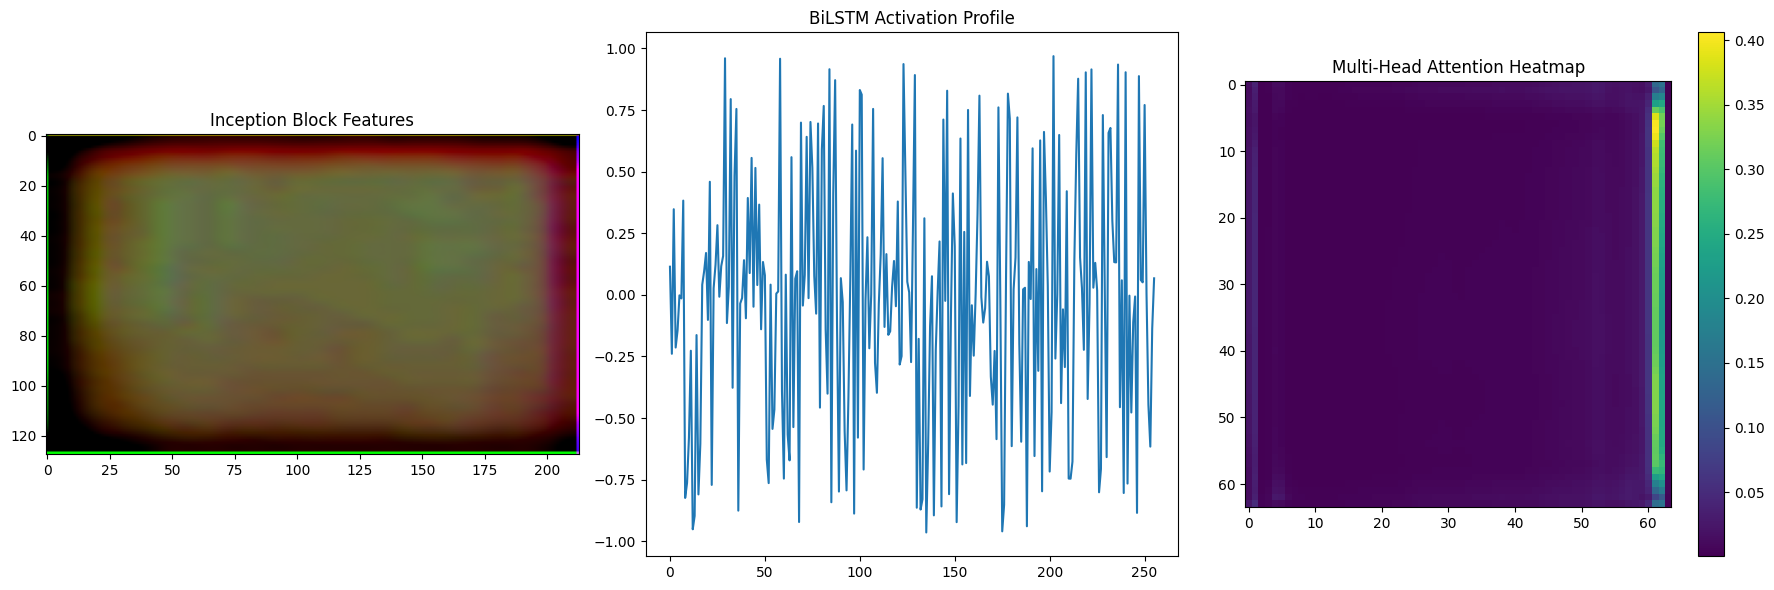

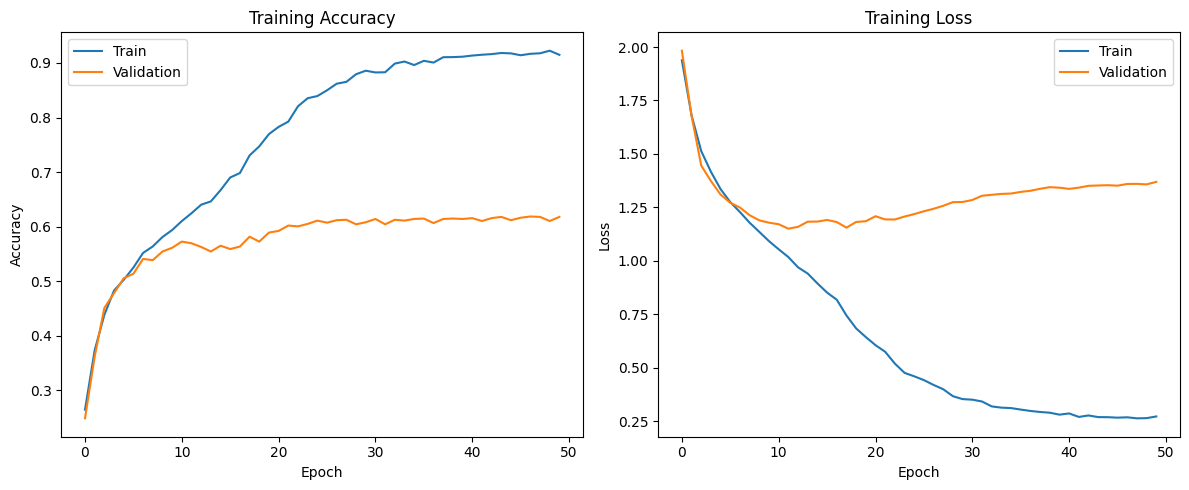


Classification Report:
                precision    recall  f1-score   support

          Cell       0.49      0.43      0.46       165
    Cell-Multi       0.40      0.50      0.44       165
      Cracking       0.69      0.66      0.67       166
         Diode       0.86      0.84      0.85       166
    No-Anomaly       0.60      0.64      0.62       166
Offline-Module       0.70      0.68      0.69       165
     Shadowing       0.63      0.64      0.64       166
    Vegetation       0.61      0.52      0.56       165

      accuracy                           0.61      1324
     macro avg       0.62      0.61      0.62      1324
  weighted avg       0.62      0.61      0.62      1324



In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 配置参数
ORIGINAL_HEIGHT = 24
ORIGINAL_WIDTH = 40
TARGET_HEIGHT = 128
TARGET_WIDTH = int(ORIGINAL_WIDTH * (TARGET_HEIGHT/ORIGINAL_HEIGHT))  # 213
BATCH_SIZE = 32
NUM_CLASSES = 8
EPOCHS = 50
SEED = 42

DATASET_DIR = r'E:\CDUT\English\7 Term\Project\model\archive\8classes'

# 修复后的Inception模块
class InceptionModule(layers.Layer):
    def __init__(self, filters, name="inception_block", **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        
        # 分支1: 1x1卷积
        self.branch1 = models.Sequential([
            layers.Conv2D(filters[0], (1,1), padding='same', activation='relu'),
        ])
        # 分支2: 1x1 + 3x3卷积
        self.branch2 = models.Sequential([
            layers.Conv2D(filters[1], (1,1), padding='same', activation='relu'),
            layers.Conv2D(filters[2], (3,3), padding='same', activation='relu')
        ])
        # 分支3: 1x1 + 5x5卷积
        self.branch3 = models.Sequential([
            layers.Conv2D(filters[3], (1,1), padding='same', activation='relu'),
            layers.Conv2D(filters[4], (5,5), padding='same', activation='relu')
        ])
        # 分支4: 3x3池化 + 1x1卷积
        self.branch4 = models.Sequential([
            layers.MaxPooling2D((3,3), strides=(1,1), padding='same'),
            layers.Conv2D(filters[5], (1,1), padding='same', activation='relu')
        ])
        
    def call(self, inputs):
        return layers.concatenate([
            self.branch1(inputs),
            self.branch2(inputs),
            self.branch3(inputs),
            self.branch4(inputs)
        ], axis=-1)
    
    # 新增get_config方法
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters
        })
        return config

# 多头注意力机制（保持原实现）
class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, name="multihead_attn", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.Wq = layers.Dense(key_dim * num_heads)
        self.Wk = layers.Dense(key_dim * num_heads)
        self.Wv = layers.Dense(key_dim * num_heads)
        self.dense = layers.Dense(key_dim * num_heads)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # 生成Q,K,V
        Q = self.Wq(inputs)
        K = self.Wk(inputs)
        V = self.Wv(inputs)
        
        # 分割多头
        Q = tf.reshape(Q, [batch_size, -1, self.num_heads, self.key_dim])
        K = tf.reshape(K, [batch_size, -1, self.num_heads, self.key_dim])
        V = tf.reshape(V, [batch_size, -1, self.num_heads, self.key_dim])
        
        # 计算注意力分数
        attention = tf.einsum('bqhd,bkhd->bhqk', Q, K) / tf.sqrt(tf.cast(self.key_dim, tf.float32))
        attention = tf.nn.softmax(attention, axis=-1)
        
        # 应用注意力权重
        output = tf.einsum('bhqk,bkhd->bqhd', attention, V)
        output = tf.reshape(output, [batch_size, -1, self.num_heads * self.key_dim])
        
        return self.dense(output), attention
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_heads': self.num_heads,
            'key_dim': self.key_dim
        })
        return config


# 构建混合模型
def build_hybrid_model():
    inputs = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))
    
    # 初始卷积
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Inception模块（使用修复后的实现）
    x = InceptionModule([16, 16, 32, 16, 32, 16], name="inception_block")(x)
    x = layers.MaxPooling2D((2,2), name="pooling_after_inception")(x)  # 64x106
    
    # 转换为序列数据
    x = layers.Reshape((64, 106 * 96), name="reshape_to_sequence")(x)
    
    # BiLSTM层
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.3),
        name="bilstm_layer"
    )(x)
    
    # 多头注意力
    attn_output, attn_weights = MultiHeadAttention(
        num_heads=4, 
        key_dim=32,
        name="multihead_attention"
    )(x)
    x = layers.Concatenate(name="attention_concat")([x, attn_output])
    
    # 分类头
    x = layers.GlobalAveragePooling1D(name="global_pool")(x)
    x = layers.Dense(256, activation='relu', name="dense_1")(x)
    x = layers.Dropout(0.5, name="final_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="output")(x)
    
    return models.Model(inputs, outputs)

# 数据准备函数
def prepare_datasets(root_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_idx)
    
    return image_paths, np.array(labels), class_names

# 图像预处理
def preprocess_image(image, augment=False):
    image = tf.image.resize(
        image, [TARGET_HEIGHT, TARGET_WIDTH],
        method=tf.image.ResizeMethod.BICUBIC
    )
    image = tf.cast(image, tf.float32)
    
    if augment:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    return image/255.0

# 创建数据集
def create_dataset(image_paths, labels, augment=False):
    def parse_function(path, label):
        image = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
        return preprocess_image(image, augment), label
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 可视化组件
def visualize_components(model, test_dataset):
    # 创建中间模型（使用正确的层名称）
    intermediate_model = models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer("inception_block").output,
            model.get_layer("bilstm_layer").output,
            model.get_layer("multihead_attention").output[1]  # 获取注意力权重
        ]
    )
    
    # 获取样本数据
    sample_images, _ = next(iter(test_dataset.take(1)))
    features = intermediate_model.predict(sample_images)
    
    # 可视化设置
    plt.figure(figsize=(18, 6))
    
    # Inception特征图
    plt.subplot(1,3,1)
    plt.imshow(features[0][0,...,:3])  # 显示前3个通道
    plt.title('Inception Block Features')
    
    # BiLSTM激活模式
    plt.subplot(1,3,2)
    lstm_act = np.mean(features[1][0], axis=0)
    plt.plot(lstm_act)
    plt.title('BiLSTM Activation Profile')
    
    # 注意力热力图
    plt.subplot(1,3,3)
    plt.imshow(features[2][0][0], cmap='viridis')  # 第一个注意力头
    plt.colorbar()
    plt.title('Multi-Head Attention Heatmap')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 准备数据
    image_paths, labels, class_names = prepare_datasets(DATASET_DIR)
    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=0.2, stratify=labels, random_state=SEED)
    
    # 创建数据集
    train_dataset = create_dataset(X_train, y_train, augment=True)
    test_dataset = create_dataset(X_test, y_test, augment=True)
    
    # 构建模型
    model = build_hybrid_model()
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    
    # 类别权重
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    # 训练配置
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_accuracy'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # 训练模型
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks
    )
    
    # 保存最终模型
    model.save('final_model.h5', save_format='h5')
    
    # 可视化组件
    visualize_components(model, test_dataset)
    
    # 训练过程可视化
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 生成分类报告
    y_pred = np.argmax(model.predict(test_dataset), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

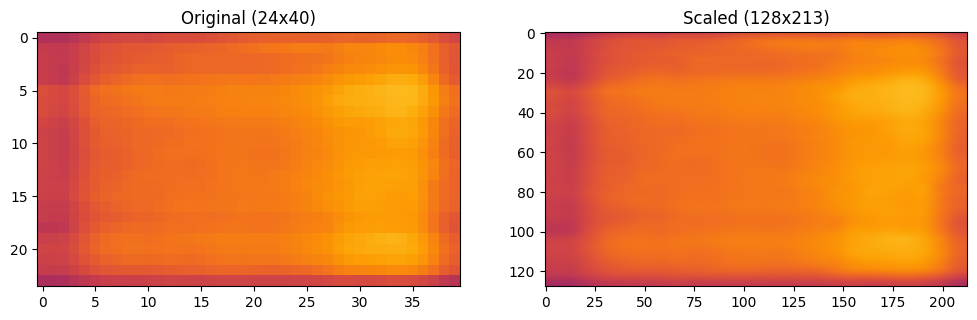

In [3]:
import matplotlib.pyplot as plt

# 添加预处理可视化检查
test_image = next(iter(train_dataset.take(1)))[0][0]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Original (24x40)")
plt.imshow(tf.image.resize(test_image, (24,40)))
plt.subplot(1,2,2)
plt.title("Scaled (128x213)")
plt.imshow(test_image)
plt.show()

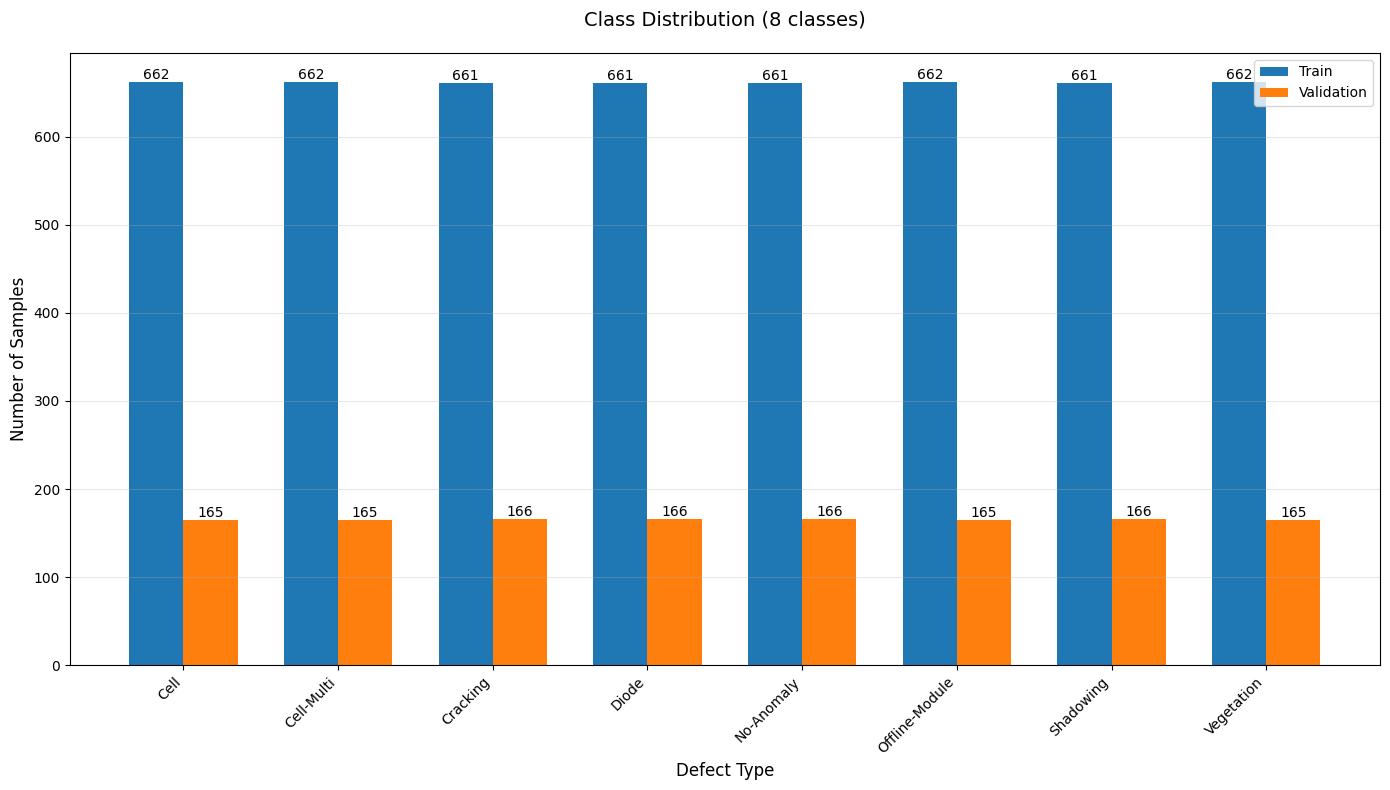

In [4]:
def plot_class_distribution(y_train, y_test, class_names):
    """可视化训练集与验证集的类别分布"""
    # 统计各类别数量
    train_counts = np.bincount(y_train, minlength=NUM_CLASSES)
    test_counts = np.bincount(y_test, minlength=NUM_CLASSES)
    
    # 创建画布
    plt.figure(figsize=(14, 8))
    
    # 设置柱状图参数
    bar_width = 0.35
    index = np.arange(NUM_CLASSES)
    
    # 颜色方案
    train_color = '#1f77b4'  # 蓝色
    test_color = '#ff7f0e'   # 橙色
    
    # 绘制柱状图
    bars_train = plt.bar(index - bar_width/2, train_counts, bar_width,
                        color=train_color, label='Train')
    bars_test = plt.bar(index + bar_width/2, test_counts, bar_width,
                       color=test_color, label='Validation')
    
    # 添加数值标签
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height}',
                     ha='center', va='bottom', fontsize=10)
    
    add_labels(bars_train)
    add_labels(bars_test)
    
    # 图表装饰
    plt.title(f'Class Distribution ({NUM_CLASSES} classes)', fontsize=14, pad=20)
    plt.xlabel('Defect Type', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(index, class_names, rotation=45, ha='right', fontsize=10)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 主流程
if __name__ == "__main__":
    # 准备数据
    image_paths, labels, class_names = prepare_datasets(DATASET_DIR)
    
    # 数据分割
    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=0.2, stratify=labels, random_state=SEED)
    
    # ==================== 新增可视化调用 ==================== 
    plot_class_distribution(
        y_train=y_train,
        y_test=y_test,
        class_names=class_names  # 直接使用原始类别名称
    )
    # ========================================================
    
    # 创建数据集（后续代码保持不变）
    train_dataset = create_dataset(X_train, y_train, augment=True)
    test_dataset = create_dataset(X_test, y_test)
    
    # ...（后续模型构建、训练等代码保持不变）

In [2]:
# Additional necessary imports
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ... (keep previous code unchanged until training completes)

if __name__ == "__main__":
    # ... (previous data preparation and training code remains unchanged)
    
    # ==================== Evaluation Code Block ====================
    # Get test set predictions
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Extract true labels
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    
    # Display prediction samples
    print("\nSample predictions comparison:")
    print("Predicted labels:", y_pred[:10])
    print("True labels:", y_true[:10])
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Multiclass ROC Curve (OvR strategy)
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Calculate metrics for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, color='darkorange',
             label=f'Macro-average ROC Curve (AUC = {auc(all_fpr, mean_tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multiclass ROC Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # ==================== PR Curve Block ====================
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette("husl", n_classes)
    
    # Plot PR curves for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
        plt.plot(recall[i], precision[i], color=colors[i], alpha=0.3,
                 label=f'{class_names[i]} (AP={average_precision[i]:.2f})')
    
    # Compute macro-average PR curve
    precision["macro"], recall["macro"], _ = precision_recall_curve(
        y_true_bin.ravel(), y_pred_probs.ravel()
    )
    average_precision["macro"] = average_precision_score(y_true_bin, y_pred_probs, average="macro")
    
    plt.plot(recall["macro"], precision["macro"], color='darkorange', lw=2,
             label=f'Macro-average (AP={average_precision["macro"]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Multiclass Precision-Recall Curve', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Key metrics output
    print("\nKey Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Macro-average Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Macro-average Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Macro-average F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Macro-average AP: {average_precision['macro']:.4f}")
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=class_names,
                                digits=4))
    # ========================================================

NameError: name 'model' is not defined

In [6]:
from numba import cuda

cuda.select_device(0)
cuda.close()